## Portfolio construction:

This code supports my blog on the Medium platform, which provides a walkthrough of the mathematical foundations behind constructing a multi-factor risk model for a portfolio and how to build a robustly diversified portfolio using this model. The portfolio's risk and the assets' risk exposures are estimated using five years of historical data from Yahoo Finance, combined with the Fama-French five-factor model dataset.

The diversification method is centered around the variation of factor exposures according to the Fama-French risk factors. I refer to this approach as Factor-Exposure-Based Diversification.

By applying this method, diversification helps reduce the portfolio's overall risk exposure.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import statsmodels.api as sm
import matplotlib.dates as mdates


warnings.filterwarnings('ignore')
plt.style.use('ggplot')

### Construction

Reusable class for estimating the risk of the constructed portfolio."

In [2]:
class portfolio_risk_and_beta_estimates(object):

    def __init__(self, list_of_tickers, return_df, risk_factors_data, factor_names):
        self.ticker_list = list_of_tickers
        self.risk_factors_df = risk_factors_data
        self.risk_factor_names = factor_names
        self.daily_ret = return_df

    def estimate_risk_exposure_and_specific_returns(self):

        betas = []
        specific_returns = []
        
        for ticker in self.ticker_list:

            df = self.daily_ret[[ticker]]
            model_data = df.merge(self.risk_factors_df, on='date').dropna()

            # for each ticker, pick the corresponding stock return time series and 
            # estimate factor betas via ordinary least square regression analysis
            ols_model = sm.OLS(endog=model_data[ticker], exog=sm.add_constant(model_data[self.risk_factor_names]))
            factor_model = ols_model.fit()
            factor_model = factor_model.params.rename({'const':'intercept'})
            
            # store the estimated factor betas into a list
            beta_estimates = pd.DataFrame(factor_model).rename(columns={0:ticker}).T.drop(['intercept'], axis=1)
            betas.append(beta_estimates)

            # calculate the specific returns and store into a list
            risk_factors = model_data.drop([ticker, 'RF'], axis=1)
            common_ret = risk_factors.dot(beta_estimates.values.T).rename(columns={0:'common_ret'})
            specific_ret = model_data[[ticker]].subtract(common_ret['common_ret'], axis=0)
            specific_returns.append(specific_ret)

        factor_exposures_df = pd.concat(betas, axis=0)
        specific_returns_df = pd.concat(specific_returns, axis=1)
        estimated_data_dict = {'beta exposures':factor_exposures_df, 
                        'specific returns':specific_returns_df,
                        'risk factors': risk_factors}
        

        return estimated_data_dict
    

    
    def estimate_portfolio_risk(self, portfolio_type, annualized_coef=252):
        '''
            The function estimate the portfolio risk using the matrix formula
            therefore, les matrix B, F, S and X are estimated first.

            inputs:
                    annualized_coef --> conventional coefficient to calculate annualized metrics in finance.
                    portfolio_type  -->  "Diverisified" or "Undiversified"
            return:
                    risk_p: the estimate portfolio risk
                     
        '''

        estimated_data = self.estimate_risk_exposure_and_specific_returns()
        # estimate annualized factor covariance matrix F
        F = annualized_coef*np.cov(estimated_data['risk factors'].T, ddof=1)
        # estimate annualized specific returns variance S
        S = annualized_coef*np.diag(estimated_data['specific returns'].var(ddof=1))
        # facor exposure matrix B
        B = estimated_data['beta exposures'].values
        # Choose portfolio weigths: for neutrality, I choose to distribute 
        # weights uniformly accross all assets of the portfolio.
        X = np.repeat(1/len(self.ticker_list), len(self.ticker_list))

        # now estimate the portfolio risk
        risk_p = np.sqrt(np.dot(np.dot(X.T, (np.dot(np.dot(B, F), B.T) + S)), X))

        print(f'\nEstimated {portfolio_type} Portfolio  Risk in Percentage:  {risk_p*100:.1f}%')


        return risk_p
    
    def estimated_portfolio_return(self, portfolio_type):
        '''
            Just estimate the portfolio of equal weights mean return.
            inputs: portfolio_typ --> "Diversified" or "Undiversified"

            returns:  mean_ret    --> portfolio's mean return
        '''

        mean_ret = 252*np.dot(self.daily_ret.mean(axis=0), np.repeat(1/len(self.ticker_list), len(self.ticker_list)))
        print(f"\nEstimated {portfolio_type} Portfolio Mean Return in Percentage: {100*mean_ret:.1f}%")

        return mean_ret


    # bar plot  the estimated risk exposures 
    def plot_estimated_risk_exposures(self, title, figure_size=(12, 5)):

        estimated_data = self.estimate_risk_exposure_and_specific_returns()
        fig, ax = plt.subplots(figsize=figure_size)
        num_tickers = len(self.ticker_list)
        num_factors = len(self.risk_factor_names)
        bar_width = 0.05
        indices = np.arange(num_factors)


        for i, ticker in enumerate(self.ticker_list):
            bar_positions = indices + i * bar_width
            ax.bar(bar_positions, estimated_data['beta exposures'].loc[ticker], width=bar_width, label=ticker)
            
        ax.set_ylabel('Exposure Level', fontsize=10)
        ax.set_title(title, fontsize=13, fontweight='bold')
                    
        ax.set_xticks(indices + bar_width * (num_factors / 2) - bar_width / 2)
        ax.set_xticklabels(self.risk_factor_names)
        plt.grid(axis='y', color='gray', linestyle='--', alpha=.3)


        ax.legend(ncol=len(self.ticker_list), title='Ticker', fontsize=7.1)
        plt.show()

    # plot the selected assets 
    def plot_selected_assets(self, close_prices, nrows, ncols, new_added_assets=[]):

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5), sharex=True)
        axes = axes.flatten()

        for i, ticker in enumerate(self.ticker_list):

            ax = axes[i]
            if ticker in new_added_assets:
                close_prices[ticker].plot(ax=ax, title=ticker, color='green')
                ax.set_title(ticker)
            else:
                close_prices[ticker].plot(ax=ax, title=ticker)
                ax.set_title(ticker)


            ax.xaxis.set_major_locator(mdates.YearLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

            plt.setp(ax.get_xticklabels(), rotation=45)               

        plt.tight_layout()         


            MARKET   SMB   HML   RMW   CMA    RF
date                                            
2019-01-02    0.23  0.74  1.13 -0.12  0.27  0.01
2019-01-03   -2.45  0.48  1.20 -0.22  0.90  0.01
2019-01-04    3.55  0.36 -0.70 -0.11 -0.59  0.01
2019-01-07    0.94  0.87 -0.75 -0.72 -0.45  0.01
2019-01-08    1.01  0.44 -0.63  0.31 -0.09  0.01


            MARKET   SMB   HML   RMW   CMA     RF
date                                             
2024-06-24   -0.26  0.63  1.11  0.00  0.65  0.022
2024-06-25    0.31 -0.81 -1.20  0.10 -1.21  0.022
2024-06-26    0.16  0.00 -0.20  0.45 -0.27  0.022
2024-06-27    0.14  0.51 -0.36 -1.01 -0.12  0.022
2024-06-28   -0.35  1.00  1.29 -0.20  0.71  0.022


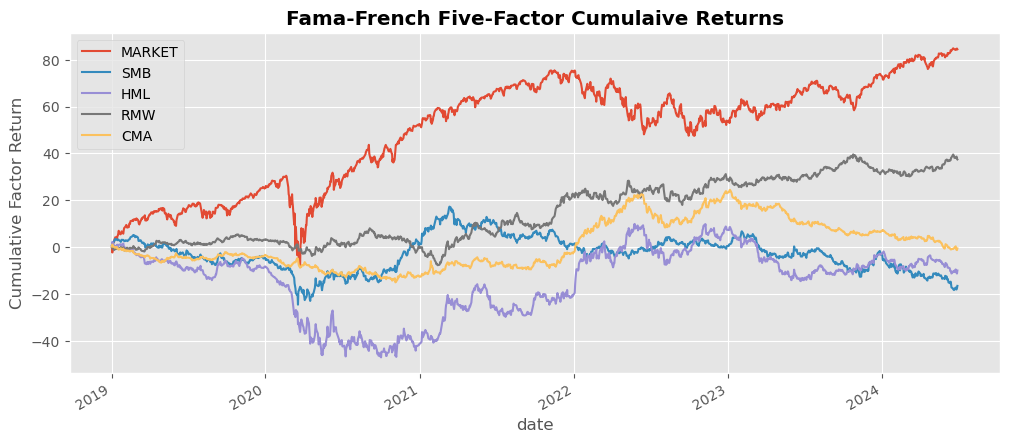

In [3]:
# download the fama-and-french-five-factor data
factor_data = (web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', 
                              start=2019)[0].rename(columns={'Mkt-RF': 'MARKET'}))
factor_data.index.names = ['date']
risk_factor_names = factor_data.columns[:-1].tolist()
print(factor_data.head())
print('\n')
print(factor_data.tail())


plt.rcParams['figure.figsize'] = (12, 5)
factor_data[risk_factor_names].cumsum().plot()
plt.ylabel('Cumulative Factor Return')
plt.title('Fama-French Five-Factor Cumulaive Returns', fontweight='bold')
plt.legend()
plt.show()

### Undiversified Portfolio

[*********************100%%**********************]  8 of 8 completed


Estimated Undiversified Portfolio  Risk in Percentage:  31.2%

Estimated Undiversified Portfolio Mean Return in Percentage: 31.3%


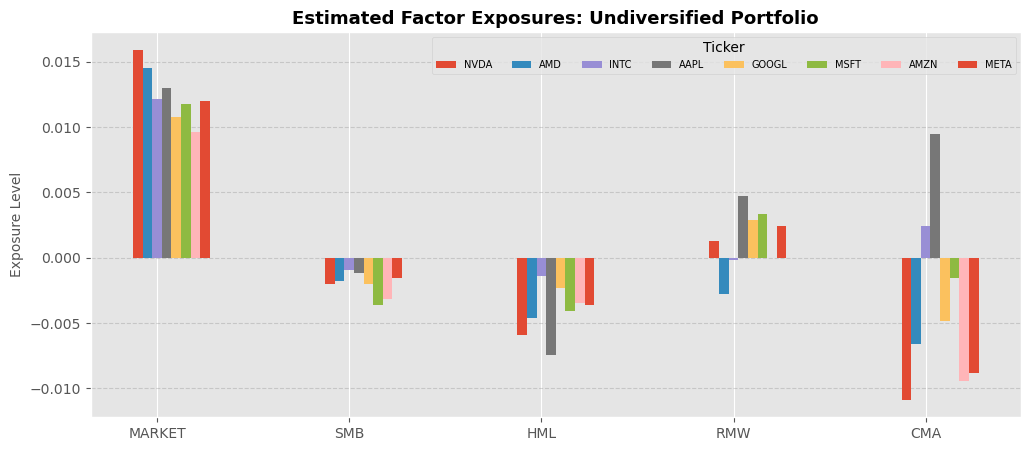

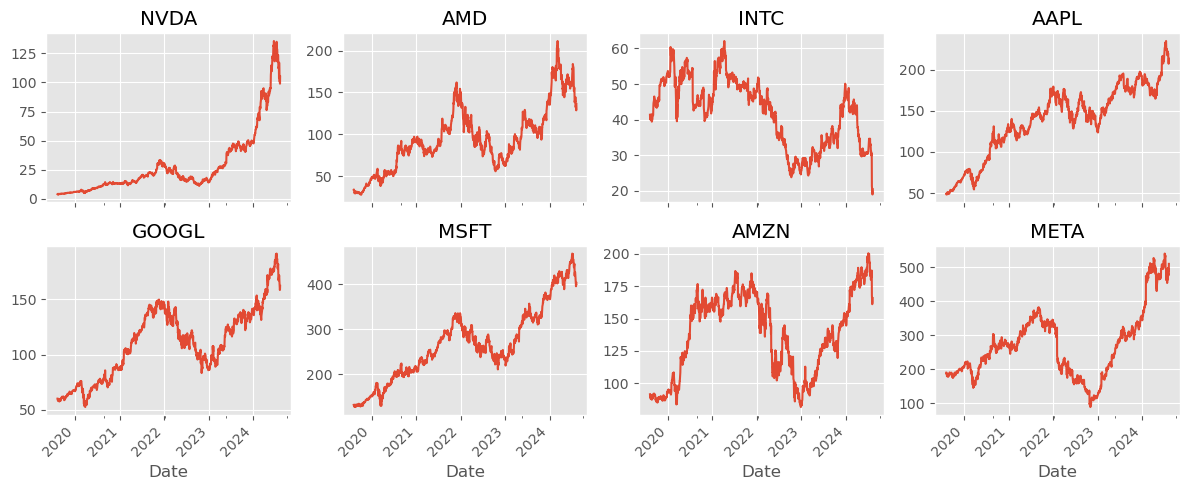

In [4]:
undiversified_ticker_list = ['NVDA', 'AMD','INTC',  'AAPL', 'GOOGL', 'MSFT', 'AMZN', 'META'] 

historical_data = yf.download(tickers=undiversified_ticker_list, start='2019-08-08', end='2024-08-09')
undiversified_close_prices = historical_data['Adj Close']
undiversified_daily_ret = undiversified_close_prices.pct_change().dropna()
# print(undiversified_daily_ret.head())
undiversified_daily_ret.index.name = 'date'
undiversified_daily_ret.columns.name = ''

undiversified_portfolio = portfolio_risk_and_beta_estimates(undiversified_ticker_list, undiversified_daily_ret, factor_data, risk_factor_names)

undiversified_risk_p = undiversified_portfolio.estimate_portfolio_risk("Undiversified", annualized_coef=252)
undiversified_mean_ret = undiversified_portfolio.estimated_portfolio_return("Undiversified")

undiversified_portfolio.plot_estimated_risk_exposures(title='Estimated Factor Exposures: Undiversified Portfolio')

undiversified_portfolio.plot_selected_assets(undiversified_close_prices, nrows=2, ncols=4)

### Diversified Portfolio

[*********************100%%**********************]  12 of 12 completed



Estimated Diversified Portfolio  Risk in Percentage:  22.2%

Estimated Diversified Portfolio Mean Return in Percentage: 24.8%


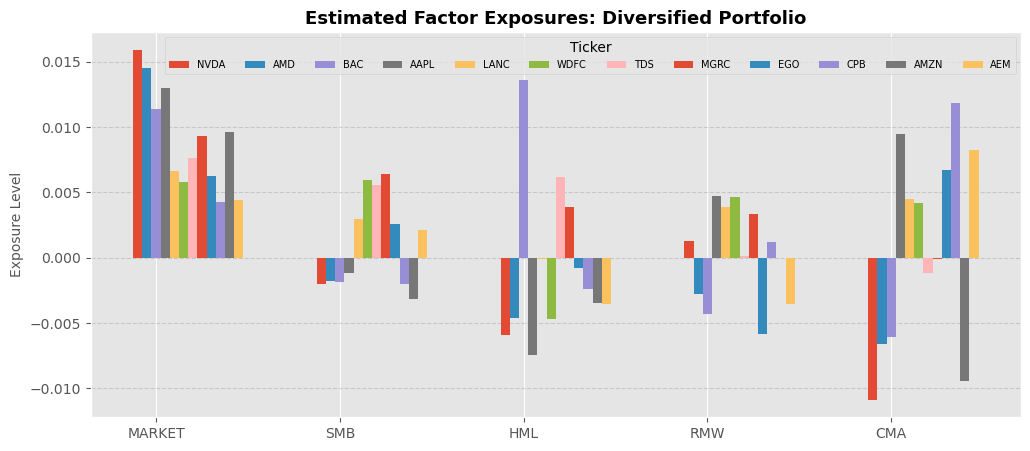

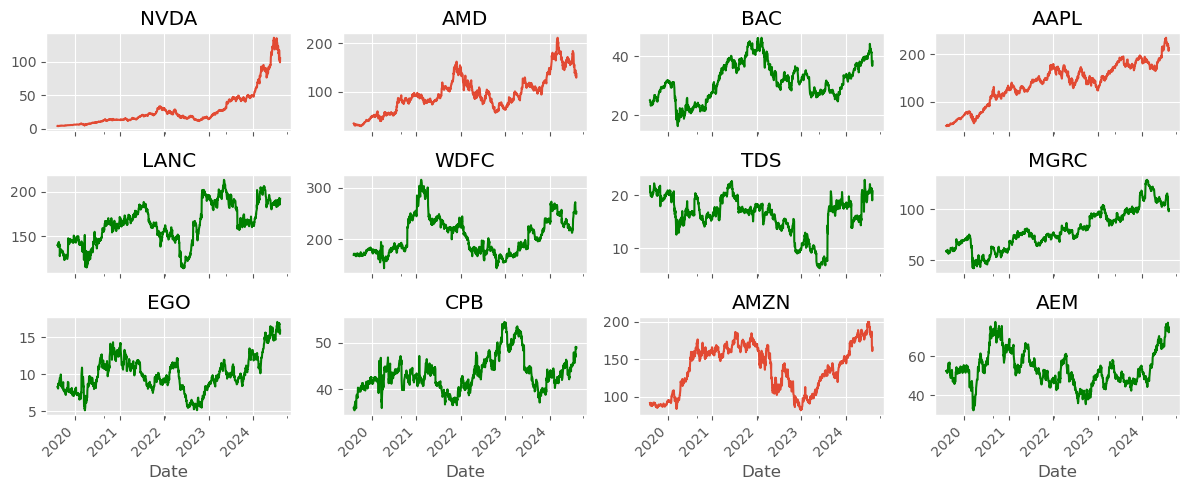

In [5]:
diversified_ticker_list = ['NVDA', 'AMD', 'BAC', 'AAPL', 'LANC', 'WDFC','TDS',  'MGRC', 'EGO', 'CPB', 'AMZN', 'AEM'] 
new_added_ticker_list = ['BAC', 'LANC', 'WDFC','TDS',  'MGRC', 'EGO', 'CPB', 'AEM']
historical_data = yf.download(tickers=diversified_ticker_list, start='2019-08-08', end='2024-08-09')
diversified_close_prices = historical_data['Adj Close']
diversified_daily_ret = diversified_close_prices.pct_change().dropna()
# print(daily_ret.head())
diversified_daily_ret.index.name = 'date'
diversified_daily_ret.columns.name = ''

diversified_portfolio = portfolio_risk_and_beta_estimates(diversified_ticker_list, diversified_daily_ret, factor_data, risk_factor_names)

diversified_risk_p = diversified_portfolio.estimate_portfolio_risk("Diversified", annualized_coef=252)
diversified_mean_ret = diversified_portfolio.estimated_portfolio_return("Diversified")


diversified_portfolio.plot_estimated_risk_exposures(title='Estimated Factor Exposures: Diversified Portfolio')


diversified_portfolio.plot_selected_assets(diversified_close_prices, nrows=3, ncols=4, new_added_assets=new_added_ticker_list)


### Diversification result

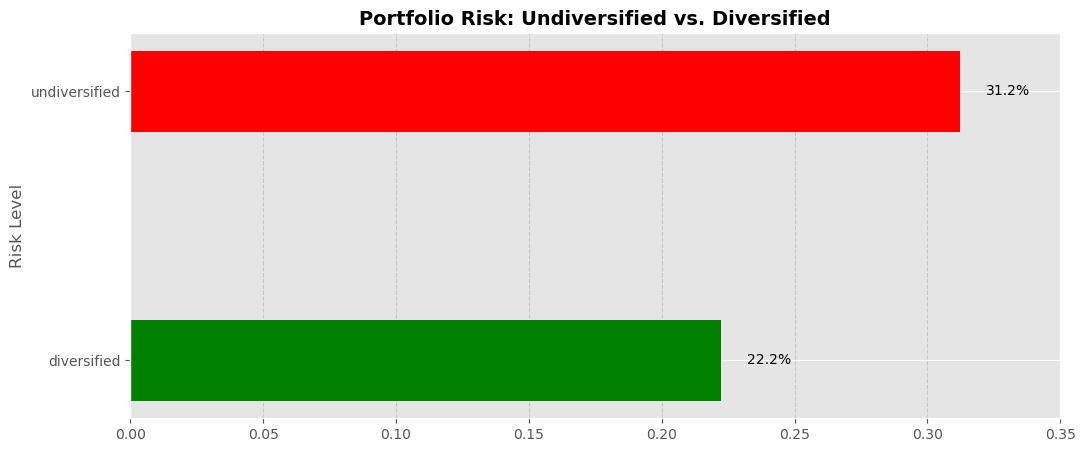

In [6]:
risk_df = pd.DataFrame({'undiversified':[undiversified_risk_p], 'diversified':[diversified_risk_p]}, index=['portfolio_risk'])


fig, ax = plt.subplots()

ax.barh('diversified', risk_df['diversified'], color='green', height=0.3)
ax.barh('undiversified', risk_df['undiversified'], color='red', height=0.3)


ax.text(risk_df['diversified'] + 0.01, 0, '22.2%', va='center')
ax.text(risk_df['undiversified'] + 0.01, 1, '31.2%', va='center')


plt.ylabel('Risk Level')
plt.title('Portfolio Risk: Undiversified vs. Diversified', fontsize=14, fontweight='bold')

plt.xlim(0, 0.35)

plt.grid(axis='x', color='gray', linestyle='--', alpha=.3)

plt.xticks(rotation=0)
plt.show()


In [7]:
undiversified_mean_ret

0.313355784509289

### Annualizey Return

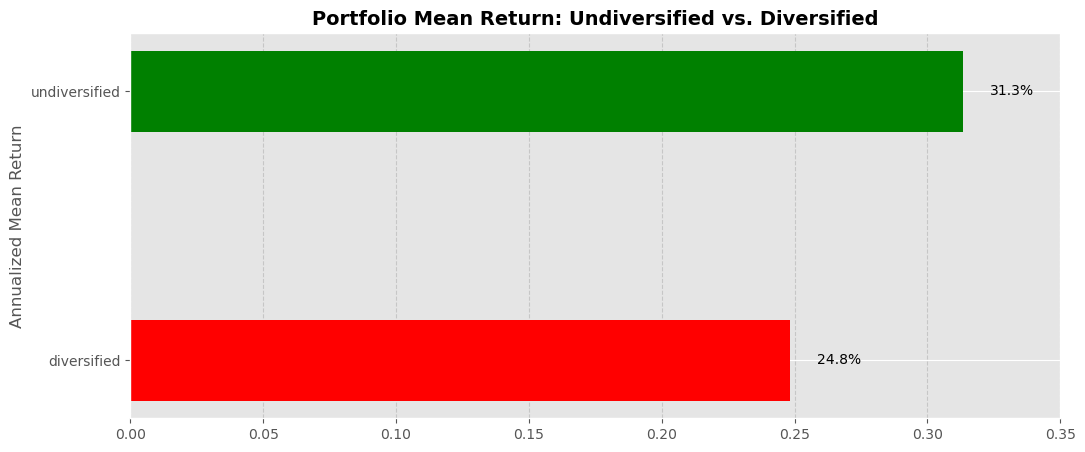

In [8]:
mean_ret_df = pd.DataFrame({'undiversified':[undiversified_mean_ret], 'diversified':[diversified_mean_ret]}, index=['portfolio_return'])


fig, ax = plt.subplots()

ax.barh('diversified', mean_ret_df['diversified'], color='red', height=0.3)
ax.barh('undiversified', mean_ret_df['undiversified'], color='green', height=0.3)



ax.text(mean_ret_df['diversified'] + 0.01, 0, '24.8%', va='center')
ax.text(mean_ret_df['undiversified'] + 0.01, 1, '31.3%', va='center')


plt.ylabel('Annualized Mean Return')
plt.title('Portfolio Mean Return: Undiversified vs. Diversified', fontsize=14, fontweight='bold')

plt.xlim(0, 0.35)

plt.grid(axis='x', color='gray', linestyle='--', alpha=.3)

plt.xticks(rotation=0)
plt.show()
